## Neuromatch Academy 2020 -- Bayes Day (dry run)
# Tutorial 4 - Marginalization & Fitting to data

Please execute the cell below to initialize the notebook environment

In [1]:
# @title
import time                        # import time 
import numpy as np                 # import numpy
import scipy as sp                 # import scipy
import math                        # import basic math functions
import random                      # import basic random number generator functions

import matplotlib.pyplot as plt    # import matplotlib
import matplotlib as mpl
from IPython import display        
from scipy.optimize import minimize    

fig_w, fig_h = (6, 4)
plt.rcParams.update({'figure.figsize': (fig_w, fig_h)})
#plt.style.use('ggplot')
mpl.rc('figure', max_open_warning = 0)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def my_gaussian(x_points, mu, sigma):
    """
    Returns un-normalized Gaussian estimated at points `x_points`, with parameters: `mu` and `sigma`
    
    Args :
      x_points (numpy arrays of floats)- points at which the gaussian is evaluated
      mu (scalar) - mean of the Gaussian
      sigma (scalar) - std of the gaussian

    Returns: 
      un-normalized Gaussian (i.e. without constant) evaluated at `x`
    """
    return np.exp(-(x_points-mu)**2/(2*sigma**2))

def moments_myfunc(x_points, function):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns the mean, median and mode of an arbitrary function

  Args : 
    x_points (numpy array of floats) - x-axis values
    function (numpy array of floats) - y-axis values of the function evaluated at `x_points`

  Returns:
    (tuple of 3 scalars): mean, median, mode
  """
  
  # Calc mode of arbitrary function
  mode = x_points[np.argmax(function)]

  # Calc mean of arbitrary function
  mean = np.sum(x_points * function)

  # Calc median of arbitrary function
  cdf_function = np.zeros_like(x_points)
  accumulator = 0
  for i in np.arange(x.shape[0]):
    accumulator = accumulator + function[i]
    cdf_function[i] = accumulator
  idx = np.argmin(np.abs(cdf_function - 0.5))
  median = x_points[idx]

  return mean, median, mode

---

### Tutorial objectives
  
In this notebook we'll have a look at computing the Marginalization Matrix and the Marginal in order to perform model inversion (i.e.: recovering the model parameters given a participant's data). 

The generative model will be the same Bayesian model we have been using in Tutorial 3 (Mixture of Gaussian Prior and Gaussian Likelihood).


---
### EXERCISE 1: Mixture of Gaussian prior
   
Similarly to Tutorial 2, we now want to create a prior matrix using a mixture of gaussians prior.

**Suggestions**

Using the equation for the un-normalised Gaussian `my_gaussian`
* Generate a Gaussian with mean 0 and standard deviation 0.5
* Generate another Gaussian with mean 0 and standard deviation 10
* Combine the two Gaussians to make a new prior by mixing the two Gaussians with mixing parameter alpha = 0.05. Make it such that the peakier Gaussian has 95% of the weight (don't forget to normalize afterwards)
* This will be the first row of your prior matrix
* Now repeat (hint: use np.tile) that row prior to make a matrix of 1000 (i.e. `hypothetical_stim.shape[0]`)  row-priors.
* Plot the matrix using the function `plt.matshow` already pre-written and commented-out in your script

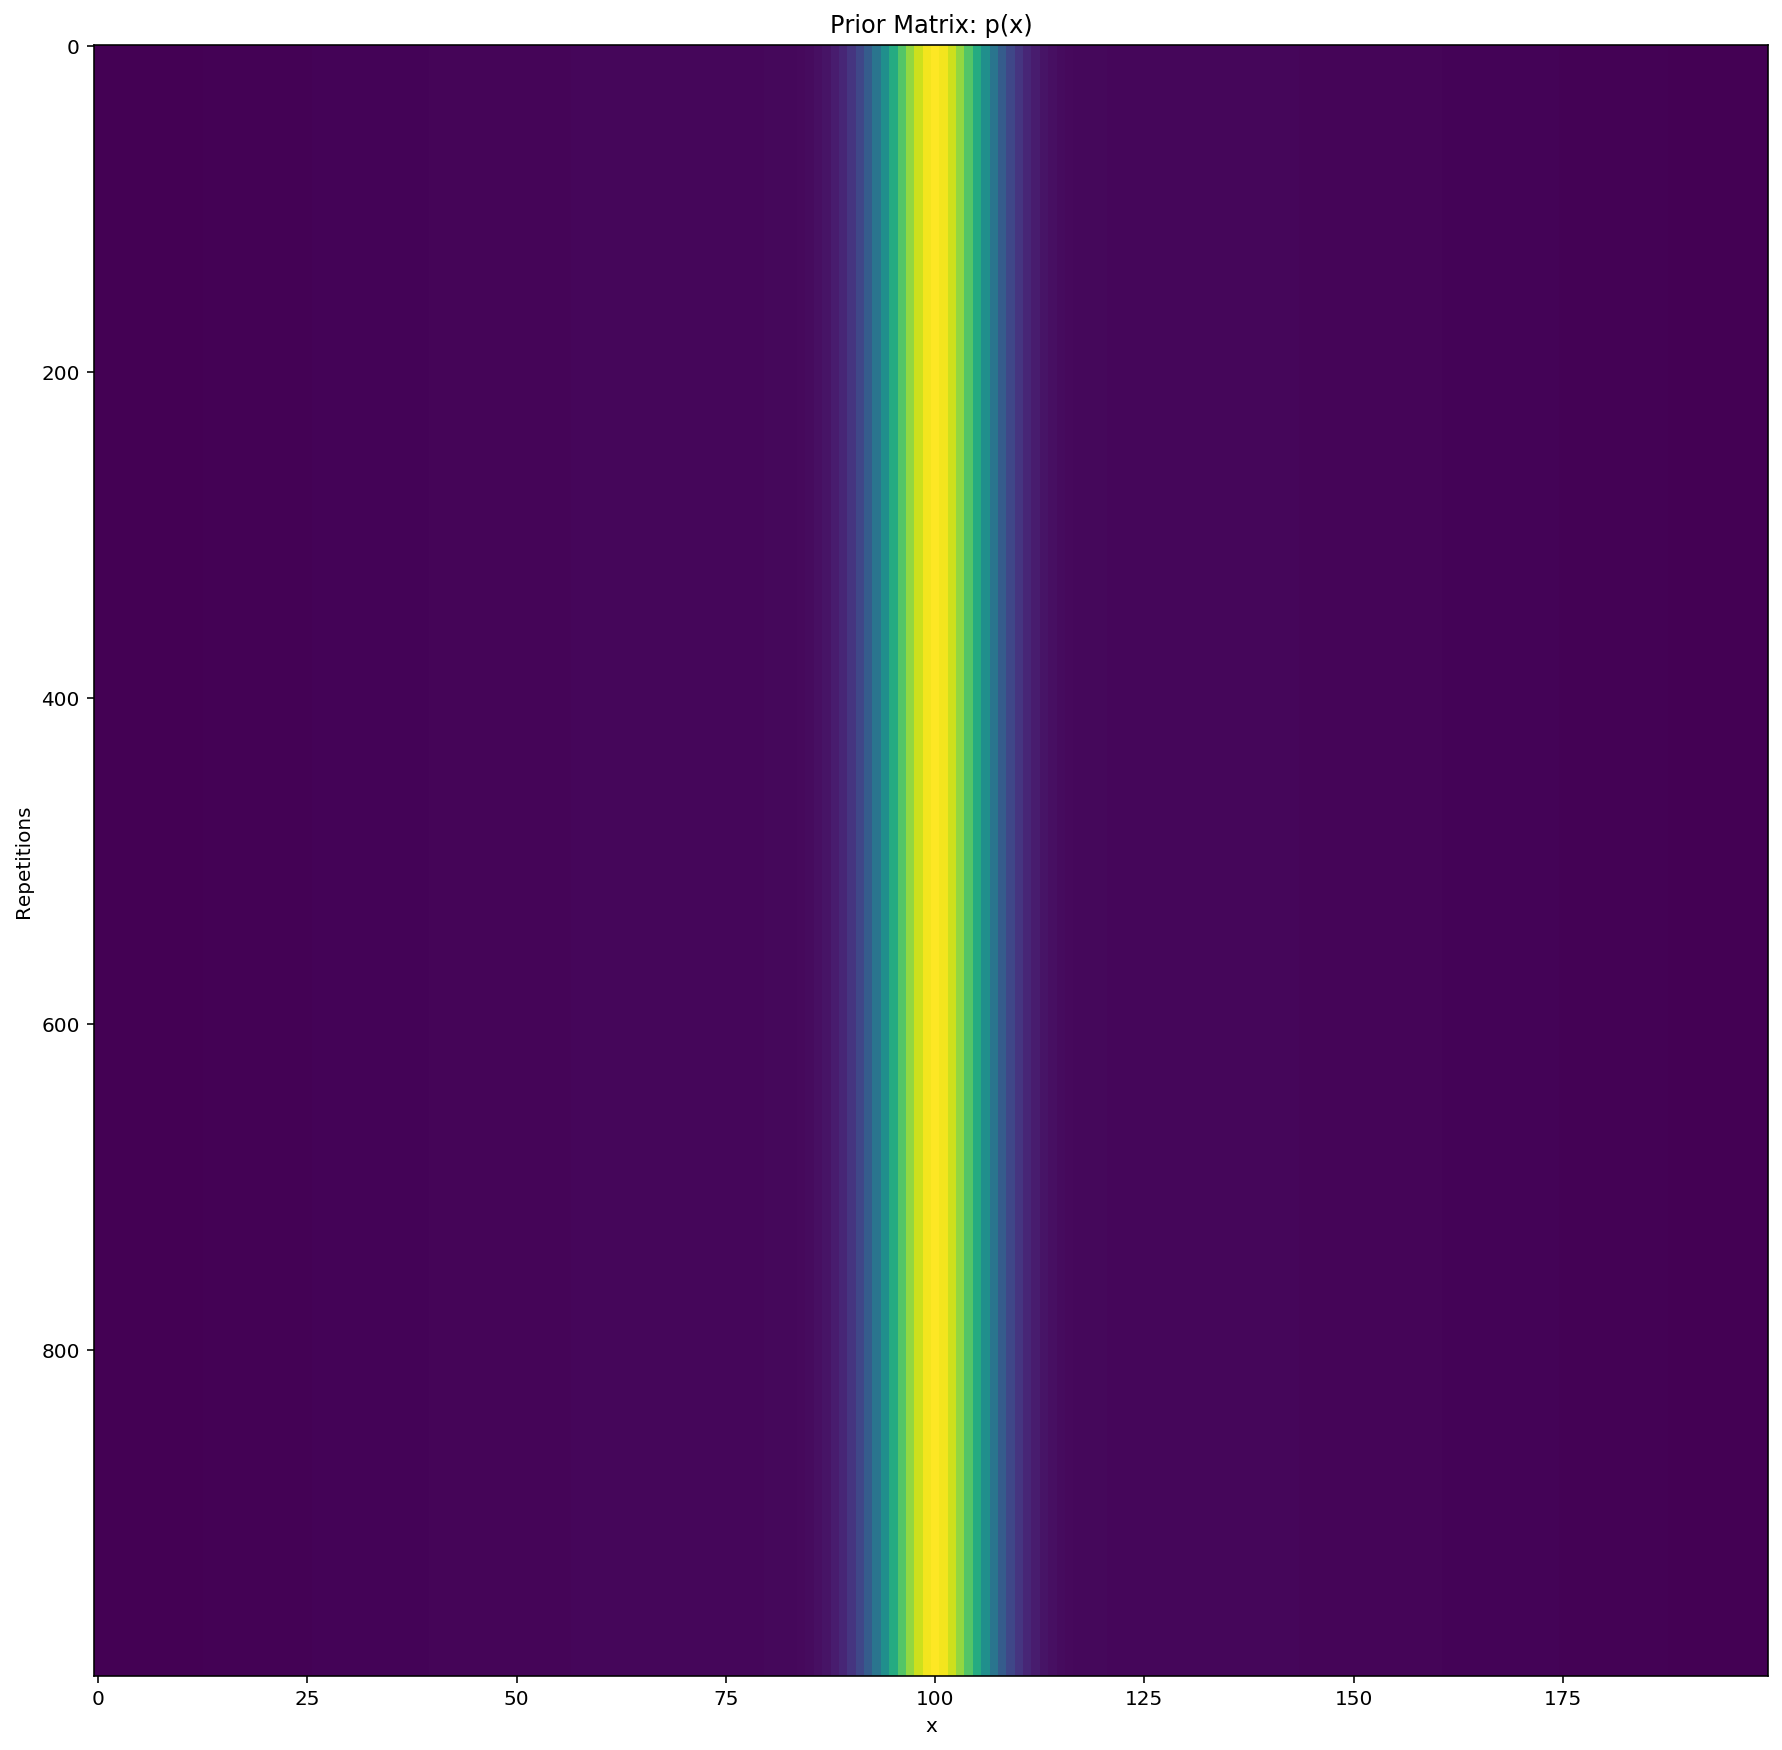

In [4]:
hypothetical_stim = np.linspace(-8,8,1000)
x = np.arange(-10,10,0.1)

##################
## Insert your code here to:
##       - Generate a mixture of gaussian prior with mean 0 and std 0.5 and 10 respectively
##       - Tile that row prior in order to make a matrix of 1000 row priors
##         (Hint: use np.tile() and np.reshape())
##       - Plot the Prior Matrix using the code snippet commented-out below
##################
prior1 = my_gaussian(x, 0, 0.5)
prior2 = my_gaussian(x, 0, 10)
alpha = 0.05
combined_prior = (1-alpha)*prior1 + alpha*prior2
combined_prior = combined_prior / np.sum(combined_prior)
prior_matrix = np.tile(combined_prior, (1000, 1))
np.shape(prior_matrix)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(prior_matrix)
ax.set_xlabel('x')
ax.set_title('Prior Matrix: p(x)')
ax.set_ylabel('Repetitions')
ax.set_aspect('auto')

---
### EXERCISE 2: Implement a Likelihood Matrix
    
We now want to create a Likelihood matrix that is made up of a Gaussian on each row of the matrix. Each row represents a different hypothetically presented stimulus with a different stimulus offset (i.e. a different likelihood mean).

**Suggestions**

  Using the equation for the un-normalised Gaussian `my_gaussian` and the values in `hypothetical_stim`:
* Create a Gaussian likelihood with mean varying from `hypothetical_stim`, keeping $\sigma$ constant at 1.
* Each Likelihood with a different mean will make up a different row-likelihood of your matrix, such that you end up with a Likelihood matrix made up of 1000 row-Gaussians with different means.
* Plot the matrix using the function `plt.matshow` already pre-written and commented-out in your script

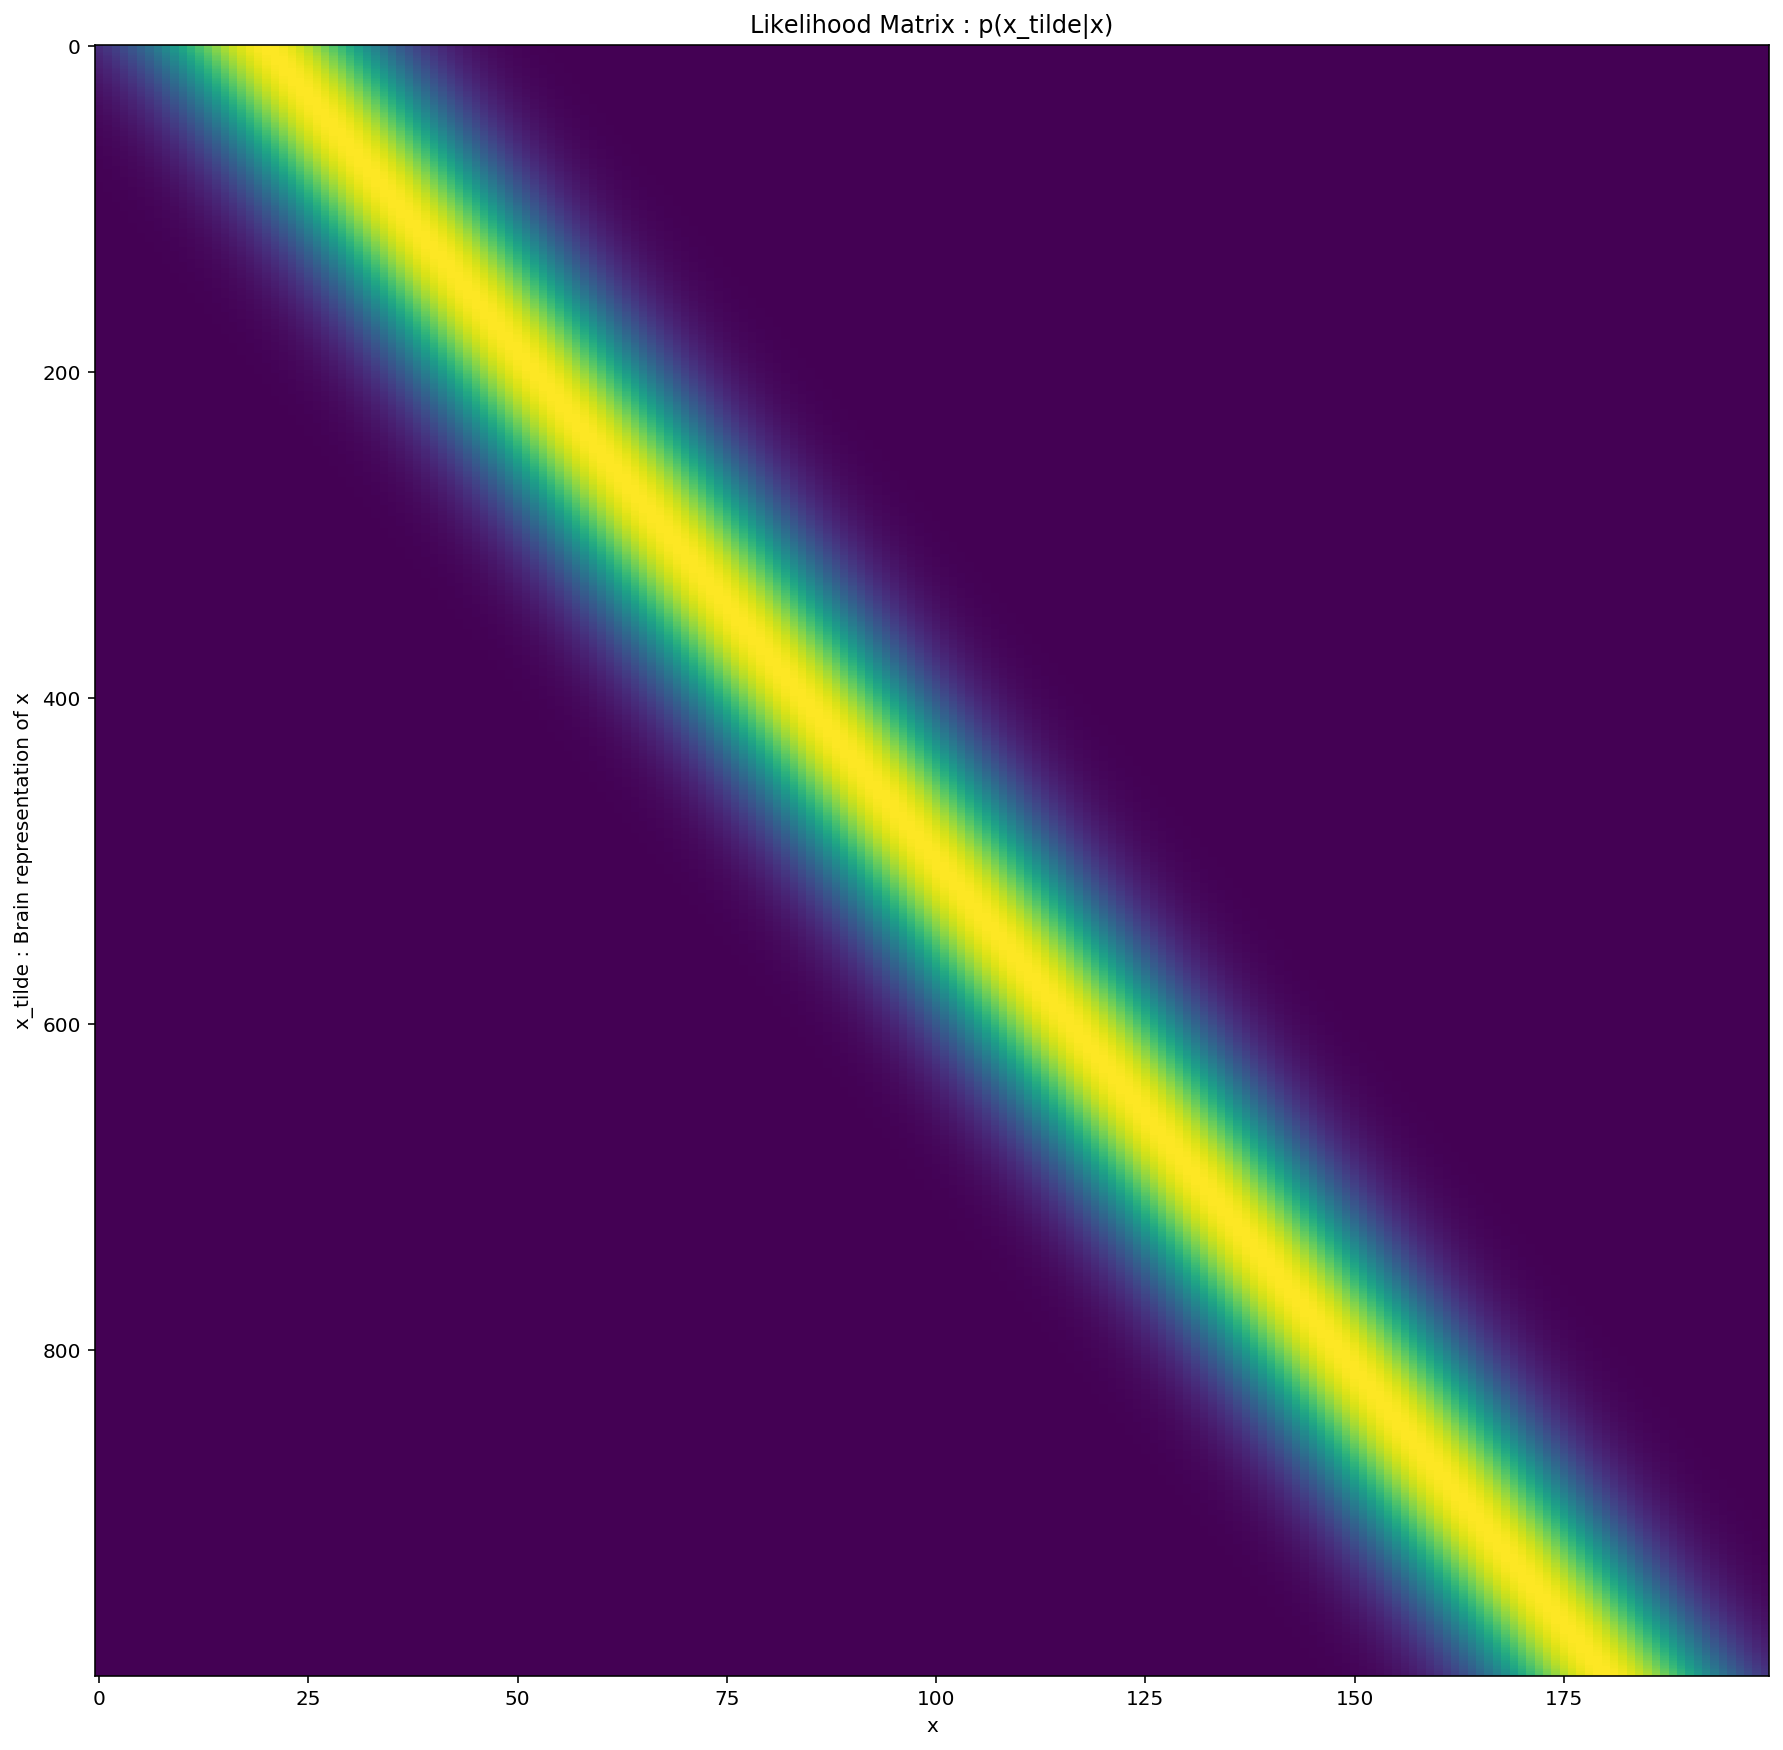

In [6]:
likelihood_matrix = np.zeros_like(prior_matrix)

##################
## Insert your code here to:
##       - Generate a likelihood matrix using `my_gaussian` function, with sigma = 1,
##         and varying the mean using `hypothetical_stim` values.
##       - Plot the Prior Matrix using the code snippet commented-out below
##################
likelihood_matrix = np.empty_like(prior_matrix)
for ii in np.arange(len(hypothetical_stim)):
    likelihood_matrix[ii,:] = my_gaussian(x, hypothetical_stim[ii], 1)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(likelihood_matrix)
ax.set_xlabel('x')
ax.set_title('Likelihood Matrix : p(x_tilde|x)')
ax.set_ylabel('x_tilde : Brain representation of x')
ax.set_aspect('auto')

---
### EXERCISE 3: Implement the Posterior Matrix
    
We now want to create the Posterior matrix. To do so, we will compute the posterior using *Bayes rule* for each trial (i.e. row_wise).

That is, each row of the posterior matrix will be the posterior resulting from the multiplication of the prior and likelihood of the equivalent row.

Mathematically:

\begin{eqnarray}
    Posterior\left[i, :\right] \propto Likelihood\left[i, :\right] \odot Prior\left[i, :\right]
\end{eqnarray}

where $\odot$ represent the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e. the element_wise multiplication) of the Prior and Likelihood row vectors `i` from the matrix.

**Suggestions**

* For each row (trial) of the Prior and Likelihood matrix, calculate posterior and fill in the Posterior matrix, such that each row of the Posterior matrix is represent the posterior for a different trial.
* Plot the matrix using the function `plt.matshow` already pre-written and commented-out in your script

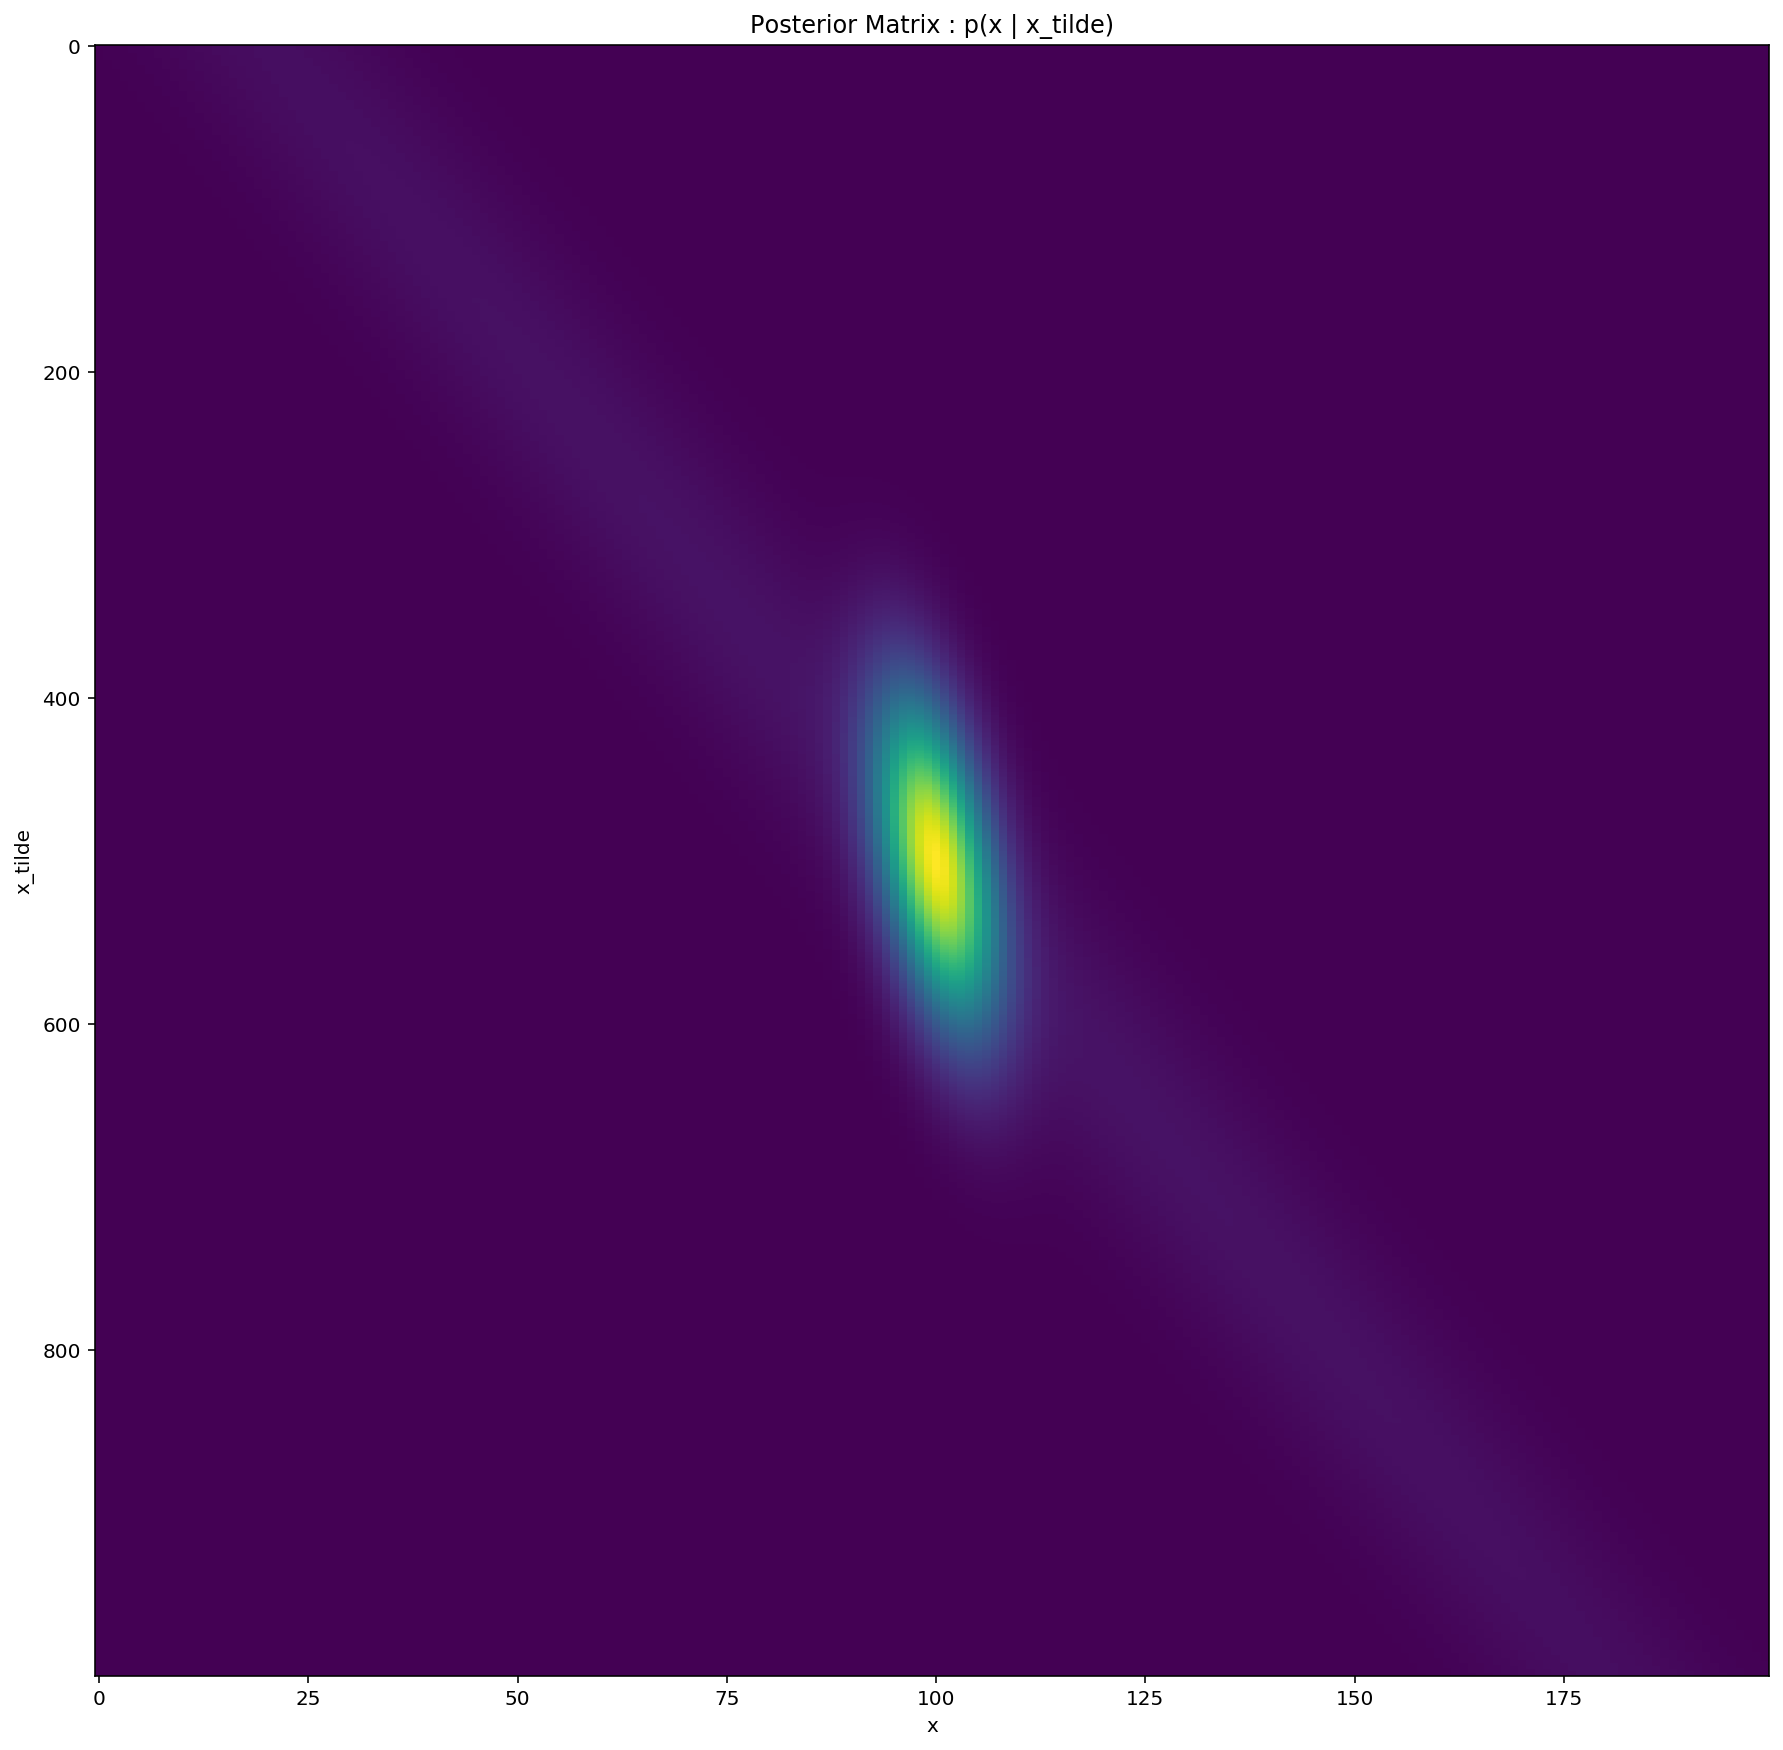

In [9]:
posterior_matrix = np.zeros_like(likelihood_matrix)

###############################################################################
## Insert your code here to:
##        For each row of the Prior & Likelihood Matrices, calculate the resulting posterior 
##        Fill the Posterior Matrix with the row_posterior
##        Plot the Posterior Matrix using the code snippet provided below
###############################################################################
posterior_matrix = np.empty_like(prior_matrix)
for idx in np.arange(np.shape(prior_matrix)[0]):
    posterior_matrix[idx,:] = prior_matrix[idx,:] * likelihood_matrix[idx,:]

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(posterior_matrix)
ax.set_xlabel('x')
ax.set_title('Posterior Matrix : p(x | x_tilde)')
ax.set_ylabel('x_tilde')
ax.set_aspect('auto')

---
### EXERCISE 4: Implement the Binary Decision Matrix
    
We now want to create the a Binary Decision Matrix. To do so, we will scan the Posterior matrix (i.e. row_wise), and set the matrix cell to 1 at the mean of the row posterior.


This, effectively encodes the *decision* that a participant may make on a given trial (i.e. row). In this case, the modelled decision rule is to take the mean of the posterior on each trial (use the function `moments_myfunc()` provided to calculate the mean of the posterior).

**Suggestions**
* For each row (trial) of the Posterior matrix, calculate the mode of the posterior, and set the corresponding cell of the Binary Decision Matrix to 1. (e.g. if the mode of the posterior is at position 0, then set the cell with x_column == 0 to 1).
* Plot the matrix using the function `plt.matshow` already pre-written and commented-out in your script

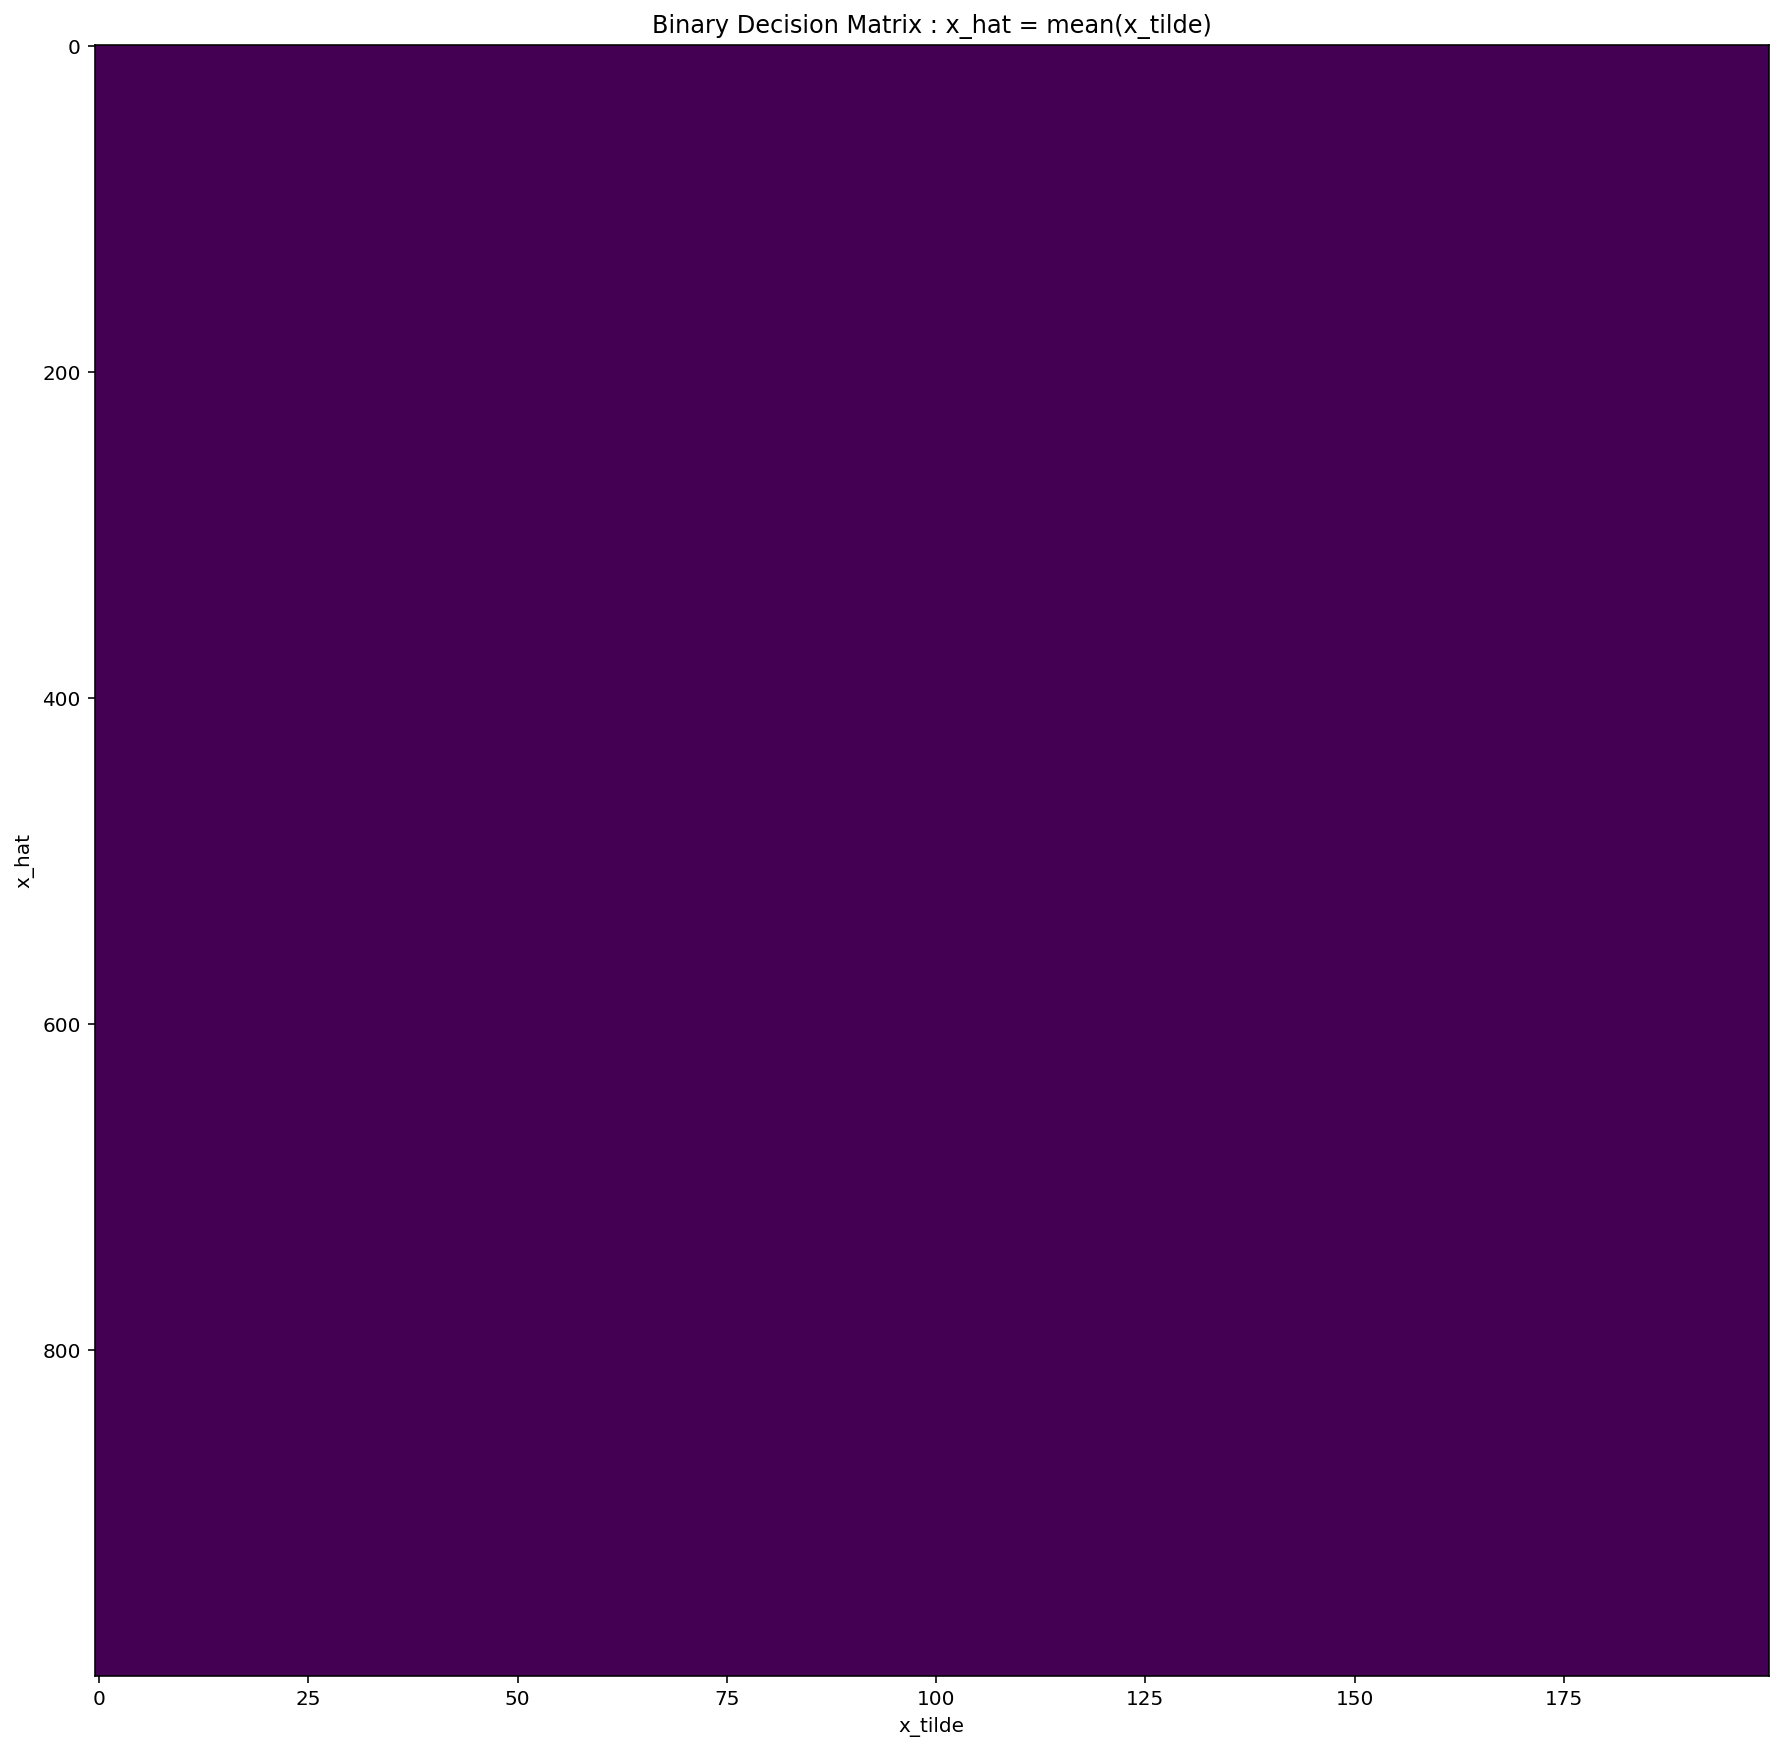

In [23]:
binary_decision_matrix = np.zeros_like(posterior_matrix)

###############################################################################
## Insert your code here to:
##        Create a matrix of the same size as the Posterior matrix and fill it with zeros (Hint: use np.zeros_like())
##        For each row of the Posterior Matrix, calculate the mean of the posterior using the function povided `moments_myfunc()`, and set the corresponding cell of the Binary Decision Matrix to 1. 
##        Plot the Posterior Matrix using the function `plt.pcolor` and the code snippet provided below
###############################################################################
for ii in range(np.shape(binary_decision_matrix)[0]):
    row_mean, _, _ = moments_myfunc(x, posterior_matrix[ii,:])
    col_idx = np.abs(posterior_matrix[ii,:] - row_mean) < 1e-6
    binary_decision_matrix[ii, col_idx] = 1

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
ax.imshow(binary_decision_matrix)
ax.set_xlabel('x_tilde')
ax.set_title('Binary Decision Matrix : x_hat = mean(x_tilde)')
ax.set_ylabel('x_hat')
ax.set_aspect('auto')

In [25]:
row_mean

0.34218009703339725

---
### EXERCISE 5: Implement the Input Matrix
    
We now want to create the Input Matrix from the true presented stimulus. That is, we will now create a Gaussian centered around the true presented stimulus, with sigma = 1. and repeat that gaussian distribution across x values. That is we want to make a *Column* gaussian centered around the true presented stimulus, and repeat this *Column* Gaussian across all values of the x-axis matrix.

This, effectively encodes the distribution of the true stimulus (one single simulus) for that a participant on a given trial. 

**Suggestions**

Assume the true stimulus is presented at direction -2.5
* Create a Gaussian likelihood with mean = -2.5 with $\sigma$ constant at 1.
* Make this the first column of your Matrix and repeat that *column* Gaussian to fill in the True_Presented_Stimulus Matrix.
* Plot the matrix using the function `plt.matshow` already pre-written and commented-out in your script

In [ ]:
input_matrix = np.zeros_like(posterior_matrix)

##################
## Insert your code here to:
##       - Generate a gaussian centered on the true stimulus -2.5 with sigma = 1
##       - Tile that column input Gaussian in order to complete the matrix
##         (Hint: use np.tile() and np.reshape())
##       - Plot the Matrix using the code snippet commented-out below
##################

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111)
# ax.imshow(input_matrix)
# ax.set_xlabel('x')
# ax.set_title('Input Matrix: p(x_tilde | x = -2.5)')
# ax.set_ylabel('x_tilde')
# ax.set_aspect('auto')

---
### EXERCISE 5: Implement the Marginalization Matrix
    
We now want to compute the Marginalization Matrix from the true presented stimulus, and our Binary decision matrix over hypothetical stimulus inputs. 

Mathematically, this means that we want to compute:

\begin{eqnarray}
    Marginalization Matrix = Input Matrix \odot Binary Matrix
\end{eqnarray}

\begin{eqnarray}
    Marginal = \int_{x} Marginalization Matrix
\end{eqnarray}

where $\odot$ represent the [Hadamard Product](https://en.wikipedia.org/wiki/Hadamard_product_(matrices)) (i.e. the element_wise multiplication) of the Input matrix and Binary matrix.

**Suggestions**

* For each row of the Input and Binary matrix, calculate product of the two and fill in the Marginal matrix.
* Plot the matrix using the function `plt.matshow` already pre-written and commented-out in your script
* Calcualte and plot the Marginal over `x` using the code snippet commented out in your script
   - Note how the limitations of numerical integration create artifacts on your marginal 

In [ ]:
marginalization_matrix = np.zeros_like(posterior_matrix)

###############################################################################
## Insert your code here to:
##        Compute the Marginalization matrix by multiplying pointwise the Binary decision matrix over hypothetical stimuli and the Input Matrix
##        Compute the Marginal from the Marginalization matrix by summing over x (hint: use np.sum())
##        Plot the Marginalization Matrix and the resulting Marginal using the code snippet provided below
###############################################################################

# fig = plt.figure(figsize=(15,15))
# ax = fig.add_subplot(111)
# ax.imshow(marginalization_matrix)
# ax.set_xlabel('x')
# ax.set_title('Marginalization Matrix: p(x_hat | x)')
# ax.set_ylabel('x_hat')
# ax.set_aspect('auto')

# plt.figure(figsize=(15,15))
# plt.plot(x, marginal)
# plt.xlabel('x_hat')
# plt.ylabel('probability')
# plt.show()

---
### EXERCISE 6: Generate some Data

Now that we've seen how to calculate the posterior and marginalize to get $p(\hat{x} \mid x)$ we will generate some artificial data for a single participant using the `generate_data()` function provided, and mixing parameter $\alpha$ = 0.1

Please run the code below:

In [ ]:
def generate_data(x_stim, alpha):
  """
  DO NOT EDIT THIS FUNCTION !!!

  Returns the mean, median and mode of an arbitrary function

  Args : 
    x_stim (numpy array of floats) - x values at which stimuli are presented
    alpha (scalar) - mixture component for the Mixture of Gaussian prior

  Returns:
    (numpy array of floats): x_hat response of participant for each stimulus
  """
  x = np.arange(-10,10,0.1)
  x_hat = np.zeros_like(x_stim)

  prior_mean = 0
  prior_sigma1  = .5
  prior_sigma2  = 3
  prior1 = my_gaussian(x, prior_mean, prior_sigma1)
  prior2 = my_gaussian(x, prior_mean, prior_sigma2)

  prior_combined = (1-alpha) * prior1 + (alpha * prior2) 
  prior_combined = prior_combined / np.sum(prior_combined)

  for i_stim in np.arange(x_stim.shape[0]):
    likelihood_mean = x_stim[i_stim]
    likelihood_sigma  = 1
    likelihood = my_gaussian(x, likelihood_mean, likelihood_sigma)
    likelihood = likelihood / np.sum(likelihood)

    posterior = np.multiply(prior_combined, likelihood)
    posterior = posterior / np.sum(posterior)
    
    # Assumes participant takes posterior mean as 'action'
    x_hat[i_stim] = np.sum(x * posterior)
  return x_hat

random.seed(0)

# Generate data for a single participant
true_stim = np.array([-8, -4, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 8])
behaviour = generate_data(true_stim, 0.1)

# Plot of data
plt.figure(figsize=(8,6))
plt.plot(true_stim, true_stim - behaviour, '-k', linewidth=2, label='data')
plt.legend()
plt.xlabel('Position of true visual stimulus (cm)')
plt.ylabel('Participant deviation from true stimulus (cm)');

---
### EXERCISE 7: Model fitting to generated data

Now that we have generated some data and that we have seen how to calculate the posterior and marginalize to get $p(\hat{x} \mid x)$ we will attempt to recover the parameter alpha = 0.05 that was use to generate the data.

We have provided you with an incomplete function called `my_Bayes_model_mse()` that needs to be completed to perform the same computations you have performed in the previous exercises but over all the participant's trial, as opposed to a single trial.

The Likelihood, has already been constructed and will not change since they depend on hypothetical stimuli. We will however have to implement the Prior matrix since it depends on $\alpha$ as well as recomputing the Posterior, Input and the marginalization matrix to compute the marginal in order to get $p(\hat{x} \mid x)$. Using $p(\hat{x} \mid x)$, we can then compute the negative Log-Likelihood for each trial in order to find the parameter that minimizes the negative Log-Likelihood (i.e. Maximises the Log-Likelihood).

Trials are assumed to be independent from one another. Mathematically this means that we can define the negative Log-Likelihood as:


\begin{eqnarray}
    -LL = - \sum_i \log p(\hat{x_i} \mid x_i)
\end{eqnarray}

where $\hat{x_i}$ is the participant's response for trial $i$, with presented stimulus $x_i$ 

**Suggestions**

* Complete the function my_Bayes_model_mse, to calculate the Prior, Posterior,Input and Marginalization matrix on each trial
* Compute the marginal using the marginalization matrix on each trial
* Compute the negative log likelihood using the marginal and the participant's response
* Using the code snippet commented out in your script to loop over possible values of $\alpha$
* Bonus question : Use the optimization function `minimize` to find the optimal value of $\alpha$.
   - Note how the limitations of numerical integration create artifacts on your marginal and the resulting negative Log-likelihood

In [ ]:
def my_Bayes_model_mse(params):
  """
  Function fits the Bayesian model from Tutorial 3 
  
  Args : 
    params (list of positive floats):  parameters used by the model (params[0]  = posterior scaling)
            
  Returns :
    (scalar) negative log-likelihood :sum of log probabilities
  """
  

  trial_ll = np.zeros_like(true_stim)

  ###############################################################################
  ## Insert your code here to:
  ##        Compute the Prior matrix given `alpha`
  ##        Compute the Posterior matrix
  ##        Compute the Binary decision matrix
  ###############################################################################

  # Loop over stimuli
  for i_stim in np.arange(true_stim.shape[0]):
    
    ###############################################################################
    ## Insert your code here to:
    ##        Compute the Input matrix 
    ##        Compute the Marginalization matrix
    ##        Compute the Marginal
    ##        Compute and return the negative log likelihood of the participant
    ###############################################################################
    raise NotImplementedError("You need to complete this function!")

x = np.arange(-10,10,0.1)

# Plot neg-LogLikelihood for different values of alpha
alpha_tries = np.arange(0.01,0.3,0.01)
nll = np.zeros_like(alpha_tries)
for i_try in np.arange(alpha_tries.shape[0]):
  nll[i_try] = my_Bayes_model_mse(np.array([alpha_tries[i_try]]))

plt.figure(2)
plt.plot(alpha_tries, nll)
plt.xlabel('alpha value')
plt.ylabel('negative log-likelihood')
plt.axvline(alpha_tries[np.argmin(nll)])
plt.show()
print(f"Best parameters estimated, scaling parameter alpha: {alpha_tries[np.argmin(nll)]:.2f}")

# Parameters for optimization
x0 = [0.05]         # Initial guess for parameters
bounds = [(0.01,1)] # Optimization bounds

# result = minimize(...)
# print(f"Best parameters estimated using minimization function, scaling parameter alpha: {result.x[0]:.2f}")